# Extrapolating our magnification distribution below its calibration in Dai+17
using fits to simulations and the prescription in Oguri17

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.constants import c
from scipy.optimize import curve_fit
from tqdm import trange
from astropy.cosmology import FlatLambdaCDM

import sys
import os
sys.path.insert(0, os.path.abspath('../'))   
from gw_lensing_outliers import dists
from gw_lensing_outliers import transforms as trans
cosmo = FlatLambdaCDM(H0=trans.H0,Om0=trans.Om0)


TEST_LNMU = np.linspace(np.log(0.4),np.log(dists.MU_MAX),num=150)
TEST_MU = np.exp(TEST_LNMU)

np_rng = np.random.default_rng(63)

## Strong and Weak lensing
- fit parameters of Dai+ model to the weak+strong lensing model Jose made
    - do this above z=0.7 to see how closely they match to what Dai+ already has
    - do this below z=0.7 to extrapolate
- add resulting best fit values to the arrays in `dists.py`
- re-run the interpolant maker at low-z, then use that grid to re-run all results in the "plots" notebook.

In [2]:
#Read the parameters N_kappa, omega2_kappa, A_kappa from the file
data = np.loadtxt('../data/fitting_kappa_distribution.txt', skiprows=1)
zSs = data[:,0]
N_kappa_sols = data[:,1]
omega2_kappa_sols = data[:,2]
A_kappa_sols = data[:,3]
data_oguri = np.loadtxt('../data/run2_oguri_optical_depth.dat')
z_oguri = data_oguri[:,0]
tau_oguri = data_oguri[:,1]
data_hist = np.loadtxt('../data/mu_hist.txt')
mus_hist = data_hist[:,0]
dPdmu_hist = data_hist[:,1]

#Interpolate the parameters
N_kappa_interp = interp1d(zSs, N_kappa_sols)
omega2_kappa_interp = interp1d(zSs, omega2_kappa_sols)
A_kappa_interp = interp1d(zSs, A_kappa_sols)
tau_oguri_interp = interp1d(z_oguri, tau_oguri, bounds_error=False, fill_value=np.nan)
dPdmu_sl_oguri = interp1d(mus_hist, dPdmu_hist, bounds_error=False, fill_value=0.0)

In [3]:
def mu_kappa(kappa):
    return 1./(1-kappa)**2

def dP_dkappa(kappa, N_kappa, omega2_kappa, A_kappa, kappa_empt):
    """
    Compute the convergence PDF dP/dkappa as defined in Equation (2) of arXiv:1807.02584.

    Parameters:
    - kappa: float or np.ndarray, the convergence value(s)
    - N_kappa: normalization constant
    - omega_kappa: width parameter
    - A_kappa: amplitude parameter
    - kappa_empty: minimum convergence (negative value)

    Returns:
    - dP_dkappa: float or np.ndarray, the value(s) of the PDF at kappa
    """
    # Ensure kappa_empty is positive for absolute value
    abs_kappa_empty = abs(kappa_empt)

    # Compute the logarithmic term
    log_term = np.log(1 + kappa / abs_kappa_empty + 1e-20)  # Adding a small constant to avoid log(0)
    exponent = -0.5 / (omega2_kappa) * (log_term + 0.5*omega2_kappa)**2

    # Compute the correction factor
    correction = 1. + A_kappa / (1 + kappa / abs_kappa_empty + 1e-20)

    # Compute the exponential part
    exp_part = np.exp(exponent* correction)

    # Compute the denominator
    denominator = kappa + abs_kappa_empty + 1e-20  # Adding a small constant to avoid division by zero

    # Final PDF
    dP_dkappa = N_kappa * exp_part / denominator

    return dP_dkappa

def kappa_empty(z_s, Omega_M=dists.Om0, H0=dists.H0):
    """
    Compute the minimum convergence kappa_empty for a source at redshift z_s.

    Parameters:
    - z_s: Source redshift
    - Omega_M: Matter density parameter
    - H0: Hubble constant in km/s/Mpc

    Returns:
    - kappa_empty: Minimum convergence value
    """
    c_km = c / 1e3  # Speed of light in m/s

    # Comoving distance to source
    chi_s = cosmo.comoving_distance(z_s).value  # in Mpc

    def integrand(z):
        chi = cosmo.comoving_distance(z).value  # in Mpc
        dchi_dz = c_km / cosmo.H(z).value  # in Mpc
        r = chi
        r_s = chi_s
        return dchi_dz * (1 + z) * (r * (r_s - r) / r_s) 

    integral, _ = quad(integrand, 0, z_s)

    prefactor = -1.5 * Omega_M * (H0 / c_km)**2
    return prefactor * integral


def dP_dmu_wl(mu, N_kappa, omega2_kappa, A_kappa,kappa_empty_val, mu0=3.0):
    """
    Compute dP/dmu from dP/dkappa using Equation (8) and apply truncation from Equation (9).

    Parameters:
    - mu: float or np.ndarray, magnification values
    - dP_dkappa_func: function, takes kappa and returns dP/dkappa
    - mu0: float, cutoff magnification for exponential truncation (default: 3.0)

    Returns:
    - dP_dmu: float or np.ndarray, magnification PDF values
    """
    mu = np.asarray(mu)
    valid = mu > 0
    dP_mu = np.zeros_like(mu)

    # Compute kappa from mu
    kappa = 1 - 1 / np.sqrt(mu[valid]) 
    dP_kappa = dP_dkappa(kappa,N_kappa, omega2_kappa, A_kappa,kappa_empty_val)

    # Equation (8)
    dP_mu[valid] = ((1 - kappa)**3 / (2)) * dP_kappa

    # Equation (9): apply exponential cutoff
    dP_mu[valid] *= np.exp(-(mu[valid] / mu0)**4)

    return dP_mu

def dP_dmu_sl(mu,zS):
    # 1/mu^3 for mu > mu_th
    mu = np.asarray(mu)
    dP_mu = dPdmu_sl_oguri(mu)#np.zeros_like(mu)
    mu_th = 3
    valid = mu > mu_th
    dP_mu[valid] = dPdmu_sl_oguri(mu_th)*(mu_th**3) / (mu[valid]**3)
    # Normalize the PDF
    normalization = np.trapz(dP_mu, mu)
    dP_mu /= normalization
    return dP_mu * tau_oguri_interp(zS)

def dP_dmu(mu, zS):
    """
    Combined magnification distribution from weak and strong lensing.

    Parameters:
    - mu: float or np.ndarray, magnification values
    - zS: Source redshift

    Returns:
    - dP_mu: float or np.ndarray, combined magnification PDF values
    """
    N_kappa_zS = N_kappa_interp(zS)
    omega2_kappa_zS = omega2_kappa_interp(zS)
    A_kappa_zS = A_kappa_interp(zS)
    kappa_empty_zS = kappa_empty(zS)

    dPdmu_wl = dP_dmu_wl(mu, N_kappa_zS, omega2_kappa_zS, A_kappa_zS,kappa_empty_zS, mu0=3.0)
    dPdmu_sl = dP_dmu_sl(mu, zS)
    
    # Combine the two distributions
    norm = (1.-tau_oguri_interp(zS))/np.trapz(dPdmu_wl[dPdmu_wl>0], mu[dPdmu_wl>0])
    return norm*dPdmu_wl + dPdmu_sl,norm

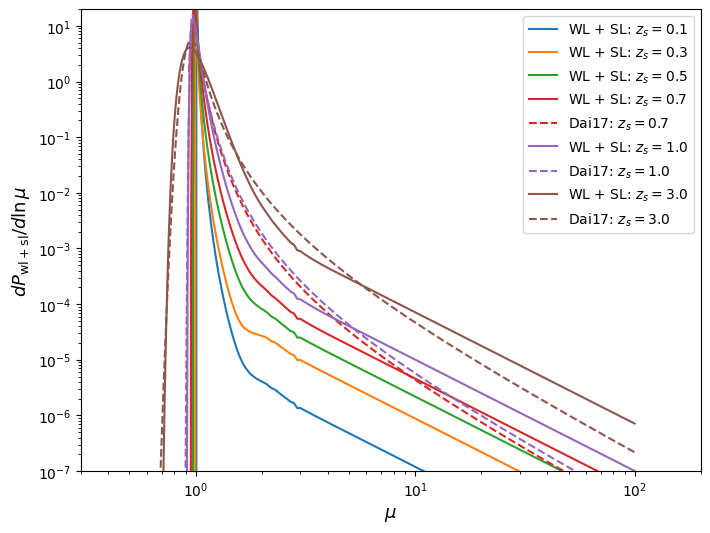

In [4]:
# Plot Jose's full magnification distribution
plt.figure(figsize=(8,6))
zSs = np.array([0.1,0.3,0.5,0.7,1.,3])
for zS in zSs:
    kappa_empty_zS = kappa_empty(zS)
    mu_min = mu_kappa(kappa_empty_zS)+ 1e-6
    mu_max = 100.
    nmus = 10000
    mus = np.linspace(mu_min, mu_max, nmus)
    dPdlnmu = mus * dP_dmu(mus, zS)[0]
    norm = dP_dmu(mus, zS)[1]
    a = plt.loglog(mus, dPdlnmu, label=r'WL + SL: $z_s = %s$' % zS)

# plot Dai
    if zS >= 0.7:
        lnmus = np.log(mus)
        color = a[0].get_color()
        plt.loglog(mus,dists.logmag_pdf(lnmus,z=zS),c=color,ls="--",label=r'Dai17: $z_s = %s$' % zS)

plt.xlim(0.3, 200)
plt.ylim(1e-7, 20)
plt.xlabel(r'$\mu$', fontsize=13)
plt.ylabel(r'$dP_\mathrm{wl+sl}/d\ln\mu$', fontsize=13)
plt.legend()
plt.show()

Ok they don't match up very well, and there's overlap where there shouldn't be. Still, lets try to fit Dai to this model in the regions where they do overlap

  0%|          | 0/6 [00:00<?, ?it/s]

/var/folders/kf/sx1t8qh956vfmhjd_cwpz19c0000gn/T/ipykernel_91524/2244757045.py:24: RuntimeWarning: divide by zero encountered in log
  numnan = np.logical_or(np.isnan(np.log(dPdlnmu)) , np.isneginf(np.log(dPdlnmu))).sum()
/var/folders/kf/sx1t8qh956vfmhjd_cwpz19c0000gn/T/ipykernel_91524/2244757045.py:29: RuntimeWarning: divide by zero encountered in log
  ydata=np.log(dPdlnmu)[numnan:],
100%|██████████| 6/6 [11:22<00:00, 113.72s/it]


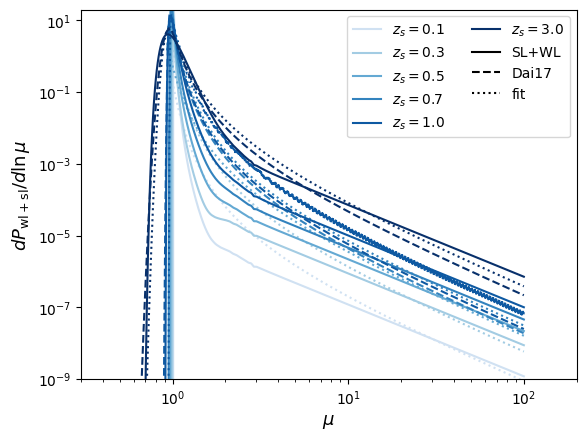

In [5]:
def func(logmags,sigma,t0,delta):
    return np.log(dists.logmag_pdf_Lambda(logmags,sigma,t0,delta,lam=5))

zSs = [0.1,0.3,0.5,0.7,1.,3.]
n_lines = len(zSs)
popts, pcovs = np.zeros((n_lines,3)),np.zeros((n_lines,3,3))

cmap = plt.colormaps['Blues']

# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0.2, 1, n_lines))

for i in trange(n_lines):
    zS = zSs[i]
    color = colors[i]
    kappa_empty_zS = kappa_empty(zS)
    mu_min = mu_kappa(kappa_empty_zS) + 1e-6
    mu_max = 100.
    nmus = 10000
    mus = np.linspace(mu_min, mu_max, nmus)
    lnmus = np.log(mus)
    dPdlnmu = mus * dP_dmu(mus, zS)[0]
    norm = dP_dmu(mus, zS)[1]
    numnan = np.logical_or(np.isnan(np.log(dPdlnmu)) , np.isneginf(np.log(dPdlnmu))).sum()
    # find nearest existing z_val for initial p guess
    nearest_z_idx = (np.abs(np.array(dists.z_vals) - zS)).argmin()
    popts[i], pcovs[i] = curve_fit(func,
                        xdata=lnmus[numnan:],
                        ydata=np.log(dPdlnmu)[numnan:], 
                        p0=[dists.sigma_vals[nearest_z_idx],dists.t0_vals[nearest_z_idx],dists.delta_vals[nearest_z_idx]],
                        bounds=([0.001,0.02,-.3],[0.2,5,-0.01]),
                        ftol=1)
    plt.loglog(mus, dPdlnmu, c=color,label=r'$z_s = %s$' % zS)
    plt.loglog(mus,dists.logmag_pdf_Lambda(lnmus,*popts[i]),c=color,ls=":")
    if zS>=0.7:
        plt.loglog(mus,dists.logmag_pdf(lnmus,z=zS),c=color,ls="--")
plt.xlim(0.3, 200)
plt.ylim(1e-9, 20)
plt.xlabel(r'$\mu$', fontsize=13)
plt.ylabel(r'$dP_\mathrm{wl+sl}/d\ln\mu$', fontsize=13)
plt.plot([],[],color='k',label='SL+WL')
plt.plot([],[],color='k',ls='--',label='Dai17')
plt.plot([],[],color='k',ls=':',label='fit')
plt.legend(ncols=2)
plt.show()


There is decent agreement at z=3, but Dai17 and SL+WL start to diverge at z=1. To make the transition smoother between the two models, we can start the fit to WL+SL at z=0.4 and continue that down to z=0.01. Let's see how that works out.

 25%|██▌       | 1/4 [00:00<00:00,  8.45it/s]/var/folders/kf/sx1t8qh956vfmhjd_cwpz19c0000gn/T/ipykernel_91524/2946038627.py:19: RuntimeWarning: divide by zero encountered in log
  numnan = np.logical_or(np.isnan(np.log(dPdlnmu)) , np.isneginf(np.log(dPdlnmu))).sum()
/var/folders/kf/sx1t8qh956vfmhjd_cwpz19c0000gn/T/ipykernel_91524/2946038627.py:26: RuntimeWarning: divide by zero encountered in log
  ydata=np.log(dPdlnmu)[numnan:],
100%|██████████| 4/4 [04:53<00:00, 73.32s/it]


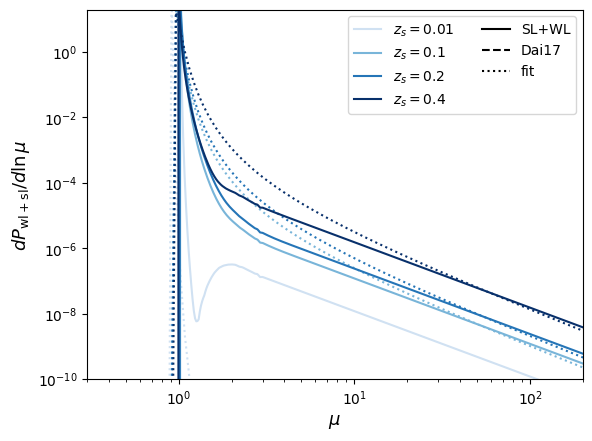

In [6]:
zSs = [0.01,0.1,0.2,0.4]
n_lines = len(zSs)
popts, pcovs = np.zeros((n_lines,3)),np.zeros((n_lines,3,3))

cmap = plt.colormaps['Blues']
colors = cmap(np.linspace(0.2, 1, n_lines))

for i in trange(n_lines):
    zS = zSs[i]
    color = colors[i]
    kappa_empty_zS = kappa_empty(zS)
    mu_min = mu_kappa(kappa_empty_zS) + 1e-6
    mu_max = 200.
    nmus = 10000
    mus = np.linspace(mu_min, mu_max, nmus)
    lnmus = np.log(mus)
    dPdlnmu = mus * dP_dmu(mus, zS)[0]
    norm = dP_dmu(mus, zS)[1]
    numnan = np.logical_or(np.isnan(np.log(dPdlnmu)) , np.isneginf(np.log(dPdlnmu))).sum()
    # manually fill an extreme version for very low z
    if zS < 0.1:
        popts[i] = [0.005,0.12,dists.delta_vals[0]]
    else:    
        popts[i], pcovs[i] = curve_fit(func,
                           xdata=lnmus[numnan:],
                           ydata=np.log(dPdlnmu)[numnan:], 
                           p0=[0.01,0.399,-0.03729578],
                           bounds=([0.001,0.02,-.045],[0.2,5,-0.01]),
                           ftol=1)
    

    plt.loglog(mus, dPdlnmu, c=color,label=r'$z_s = %s$' % zS)
    plt.loglog(TEST_MU,dists.logmag_pdf_Lambda(TEST_LNMU,*popts[i]),c=color,ls=":")
    if zS>=0.7:
        plt.loglog(mus,dists.logmag_pdf(lnmus,z=zS),c=color,ls="--")
plt.xlim(0.3, 200)
plt.ylim(1e-10, 20)
plt.xlabel(r'$\mu$', fontsize=13)
plt.ylabel(r'$dP_\mathrm{wl+sl}/d\ln\mu$', fontsize=13)
plt.plot([],[],color='k',label='SL+WL')
plt.plot([],[],color='k',ls='--',label='Dai17')
plt.plot([],[],color='k',ls=':',label='fit')
plt.legend(ncols=2)
plt.show()
# It's not great but it'll do

In [7]:
# this is what we will use in dists.py :
popts.T 

array([[ 0.005     ,  0.00728209,  0.00756015,  0.00616215],
       [ 0.12      ,  0.30726794,  0.32334431,  0.37662823],
       [-0.09714386, -0.03929844, -0.03900541, -0.03867672]])

This leaves us with the following "calibrated" values for the magnification hyperparameters:

```
z_vals = 0.01,0.1,0.2,0.4 || 1,2,3,5,10,20
sigma_vals = 0.005,  0.00728209,  0.00756015,  0.00616215 || 0.010,0.028,0.050,0.078,0.110,0.150
t0_vals = 0.12,   0.30726794,  0.32334431,  0.37662823  || 0.399,0.471,0.511,0.557,0.609,0.666
delta_vals = -0.03929844, -0.03929844, -0.03900541, -0.03867672 || -0.04545126, -0.06765865, -0.08240914, -0.10120188, -0.12460416, -0.15263525
```

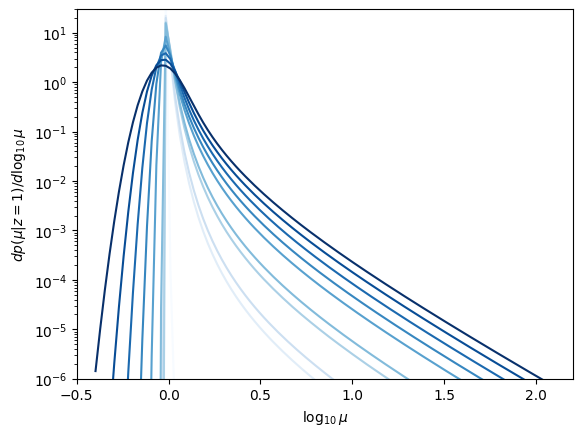

In [8]:
z_vals = [0.01,0.1,0.2,0.4, 1,2,3,5,10,20]
sigma_vals = [0.005,  0.00728209,  0.00756015,  0.00616215, 0.010,0.028,0.050,0.078,0.110,0.150]
t0_vals = [0.12,   0.30726794,  0.32334431,  0.37662823,  0.399, 0.471,0.511,0.557,0.609,0.666]
delta_vals = [-0.03929844, -0.03929844, -0.03900541, -0.03867672, -0.04545126, -0.06765865, -0.08240914, -0.10120188, -0.12460416, -0.15263525]

n_lines = len(z_vals)
colors = cmap(np.linspace(0, 1, n_lines))
f,ax = plt.subplots()
for i in range(n_lines):
    color = colors[i]
    ax.plot(np.log10(TEST_MU),dists.logmag_pdf_Lambda(TEST_LNMU,sigma=sigma_vals[i],t0=t0_vals[i],delta=delta_vals[i]), color=color)

plt.yscale("log")
plt.xlabel('$\log_{10}\mu$')
plt.ylabel('$dp(\mu|z=1)/d\log_{10} \mu$')
plt.ylim(bottom=1e-6,top=3e1)
plt.xlim(-0.5,2.2)
plt.show()

## Weak lensing only
We ended up not using this b/c it wasn't sufficient

Process:
- Figure out which parameters of the phenomenological Dai+ model (from $t_0, \delta, \sigma$) I should fit to the weak-lensing model
    - do this by trying to fit the weak lensing model with the Dai+ model where they are both defined, i.e. $z\geq0.7$.
- fit those parameters (within the Dai+ model) to the weak lensing model at $z<0.7$
- add the resulting best fit values to the $t_0, \delta, \sigma$ arrays in `dists.py`
- re-run the interpolan maker at low redshifts, use that grid moving forward.

In [2]:
# define relevant weak lensing functions
def dP_dmu(mu, N_kappa, omega2_kappa, A_kappa,kappa_empty_val, mu0=3.0):
    """
    Compute dP/dmu from dP/dkappa using Equation (8) and apply truncation from Equation (9).

    Parameters:
    - mu: float or np.ndarray, magnification values
    - dP_dkappa_func: function, takes kappa and returns dP/dkappa
    - mu0: float, cutoff magnification for exponential truncation (default: 3.0)

    Returns:
    - dP_dmu: float or np.ndarray, magnification PDF values
    """
    mu = np.asarray(mu)
    valid = mu > 0
    dP_mu = np.zeros_like(mu)

    # Compute kappa from mu
    kappa = 1 - 1 / np.sqrt(mu[valid]) 
    dP_kappa = dP_dkappa(kappa,N_kappa, omega2_kappa, A_kappa,kappa_empty_val)

    # Equation (8)
    dP_mu[valid] = ((1 - kappa)**3 / (2)) * dP_kappa

    # Equation (9): apply exponential cutoff
    dP_mu[valid] *= np.exp(-(mu[valid] / mu0)**4)

    return dP_mu


def kappa_empty(z_s, Omega_M=dists.Om0, H0=dists.H0):
    """
    Compute the minimum convergence kappa_empty for a source at redshift z_s.

    Parameters:
    - z_s: Source redshift
    - Omega_M: Matter density parameter
    - H0: Hubble constant in km/s/Mpc

    Returns:
    - kappa_empty: Minimum convergence value
    """
    c_km = c / 1e3  # Speed of light in m/s

    # Comoving distance to source
    chi_s = cosmo.comoving_distance(z_s).value  # in Mpc

    def integrand(z):
        chi = cosmo.comoving_distance(z).value  # in Mpc
        dchi_dz = c_km / cosmo.H(z).value  # in Mpc
        r = chi
        r_s = chi_s
        return dchi_dz * (1 + z) * (r * (r_s - r) / r_s) 

    integral, _ = quad(integrand, 0, z_s)

    prefactor = -1.5 * Omega_M * (H0 / c_km)**2
    return prefactor * integral

def dP_dkappa(kappa, N_kappa, omega2_kappa, A_kappa, kappa_empt):
    """
    Compute the convergence PDF dP/dkappa as defined in Equation (2) of arXiv:1807.02584.

    Parameters:
    - kappa: float or np.ndarray, the convergence value(s)
    - N_kappa: normalization constant
    - omega_kappa: width parameter
    - A_kappa: amplitude parameter
    - kappa_empty: minimum convergence (negative value)

    Returns:
    - dP_dkappa: float or np.ndarray, the value(s) of the PDF at kappa
    """
    # Ensure kappa_empty is positive for absolute value
    abs_kappa_empty = abs(kappa_empt)

    # Compute the logarithmic term
    log_term = np.log(1 + kappa / abs_kappa_empty + 1e-20)  # Adding a small constant to avoid log(0)
    exponent = -0.5 / (omega2_kappa) * (log_term + 0.5*omega2_kappa)**2

    # Compute the correction factor
    correction = 1. + A_kappa / (1 + kappa / abs_kappa_empty + 1e-20)

    # Compute the exponential part
    exp_part = np.exp(exponent* correction)

    # Compute the denominator
    denominator = kappa + abs_kappa_empty + 1e-20  # Adding a small constant to avoid division by zero

    # Final PDF
    dP_dkappa = N_kappa * exp_part / denominator

    return dP_dkappa

def mu_kappa(kappa):
    return 1./(1-kappa)**2


In [3]:
#Read the parameters N_kappa, omega2_kappa, A_kappa from Jose's file
data = np.loadtxt('../data/fitting_kappa_distribution.txt', skiprows=1)
zSs = data[:,0]
N_kappa_sols = data[:,1]
omega2_kappa_sols = data[:,2]
A_kappa_sols = data[:,3]

#Interpolate the parameters
N_kappa_interp = interp1d(zSs, N_kappa_sols)
omega2_kappa_interp = interp1d(zSs, omega2_kappa_sols)
A_kappa_interp = interp1d(zSs, A_kappa_sols)

/var/folders/kf/sx1t8qh956vfmhjd_cwpz19c0000gn/T/ipykernel_3881/1586842427.py:78: RuntimeWarning: invalid value encountered in log
  log_term = np.log(1 + kappa / abs_kappa_empty + 1e-20)  # Adding a small constant to avoid log(0)


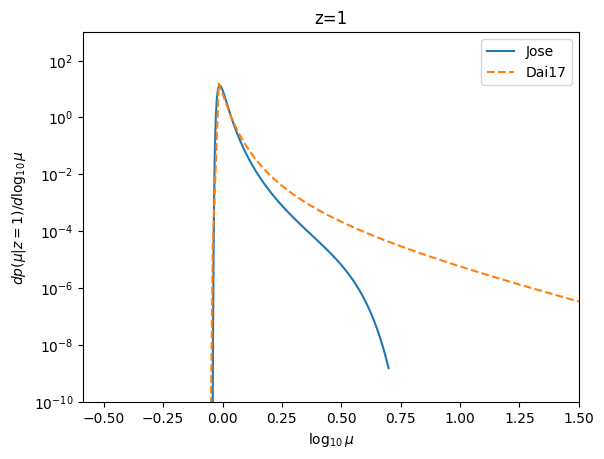

In [13]:
zS = 1

#Values from interpolation
N_kappa_zS = N_kappa_interp(zS)
omega2_kappa_zS = omega2_kappa_interp(zS)
A_kappa_zS = A_kappa_interp(zS)

# plot Jose's model
kappa_empty_zS = kappa_empty(zS)
mu_min = mu_kappa(kappa_empty_zS)
mu_max = 5.
nmus = 10000
mus = np.linspace(mu_min, mu_max, nmus)
dPdlnmu = mus * dP_dmu(mus, N_kappa_zS, omega2_kappa_zS, A_kappa_zS,kappa_empty_zS, mu0=3.0)
plt.plot(np.log10(mus),dPdlnmu, label=r'Jose')

# plot Dai
sig_at_p7, delta_at_p7, t0_at_p7 = dists.sigma_vals[1], dists.delta_vals[1], dists.t0_vals[1]
plt.plot(np.log10(TEST_MU),dists.logmag_pdf_Lambda(TEST_LNMU,sigma=sig_at_p7,t0=t0_at_p7,delta=delta_at_p7,lam=5),ls="--",label="Dai17")

plt.legend()
plt.title(f"z={zS}")
plt.yscale("log")
plt.xlabel('$\log_{10}\mu$')
plt.ylabel('$dp(\mu|z=1)/d\log_{10} \mu$')
plt.ylim(bottom=1e-10,top=1e3)
plt.xlim(right=1.5)
plt.show()

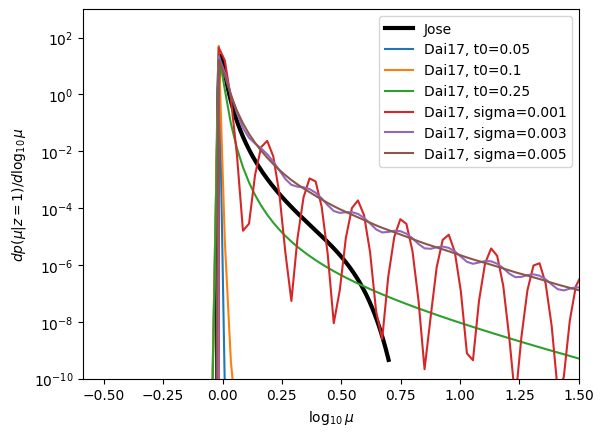

In [12]:
# plot Jose's model
kappa_empty_zS = kappa_empty(zS)
mu_min = mu_kappa(kappa_empty_zS)
mu_max = 5.
nmus = 10000
mus = np.linspace(mu_min, mu_max, nmus)
dPdlnmu = mus * dP_dmu(mus, N_kappa_zS, omega2_kappa_zS, A_kappa_zS,kappa_empty_zS, mu0=3.0)
plt.plot(np.log10(mus),dPdlnmu, label=r'Jose',lw=3,c='k')

# plot Dai model for various t0
for t0 in [0.05,0.1,0.25]:
    plt.plot(np.log10(TEST_MU),dists.logmag_pdf_Lambda(TEST_LNMU,sigma=sig_at_p7,t0=t0,delta=delta_at_p7,lam=5),label=f"Dai17, t0={t0}")
#plot it for various sigma
# plot Dai model for various t0
for sig in [1e-3,3e-3,5e-3]:
    plt.plot(np.log10(TEST_MU),dists.logmag_pdf_Lambda(TEST_LNMU,sigma=sig,t0=t0_at_p7,delta=delta_at_p7,lam=5),label=f"Dai17, sigma={sig:.3f}")

plt.legend()
plt.yscale("log")
plt.xlabel('$\log_{10}\mu$')
plt.ylabel('$dp(\mu|z=1)/d\log_{10} \mu$')
plt.ylim(bottom=1e-10,top=1e3)
plt.xlim(right=1.5)
plt.show()
